# Turbidity Deep Learning Peak Detection


In [1]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sys
from sklearn import preprocessing
from resnet import ResNet1D
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from torchsummary import summary
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    f1_score,
    balanced_accuracy_score,
)
import matplotlib.pyplot as plt
import seaborn as sn

sys.path.insert(1, "../")

from datasets import turbidityDataset, turbAugOnlyDataset


## Hyperparameters


In [2]:
# Hyperparams
WINDOW_SIZE = 15  # the size of each data segment
TEST_SIZE = 0.10
SEED = 42
BATCH_SIZE = 32


## Data Paths


In [3]:
# Paths to data files
fdom_raw_data = "../Data/converted_data/julian_format/fDOM_raw_10.1.2011-9.4.2020.csv"
stage_raw_data = "../Data/converted_data/julian_format/stage_10.1.11-1.1.19.csv"
turb_raw_data = (
    "../Data/converted_data/julian_format/turbidity_raw_10.1.2011_9.4.2020.csv"
)

turb_labeled = "../Data/labeled_data/ground_truths/turb/turb_all_julian_0k-300k.csv"

fdom_raw_augmented = "../Data/augmented_data/turb/unlabeled/unlabeled_fdom.csv"
turb_labeled_augmented = "../Data/augmented_data/turb/labeled/labeled_turb_peaks.csv"

turb_augmented_raw_data = "../Data/augmented_data/turb/unlabeled/unlabeled_turb.csv"

stage_augmented_data_fn = "../Data/augmented_data/turb/unlabeled/unlabeled_stage.csv"

turb_fpt_lookup_path = "../Data/augmented_data/turb/fpt_lookup.csv"


In [4]:
# get device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cpu


## Load Data


In [5]:
classes = ["NAP", "FPT", "PP", "SKP"]
le = preprocessing.LabelEncoder()

targets = le.fit_transform(classes)

train_dataset = turbAugOnlyDataset(
    le,
    fdom_raw_augmented,
    stage_augmented_data_fn,
    turb_augmented_raw_data,
    turb_labeled_augmented,
    turb_fpt_lookup_path,
    WINDOW_SIZE,
)

test_dataset = turbidityDataset(
    le,
    fdom_raw_data,
    stage_raw_data,
    turb_raw_data,
    turb_labeled,
    window_size=WINDOW_SIZE,
)


3169 candidates found in class-balanced augmented dataset.
1253 candidates found in test dataset.


### Collate function

This pads the dataset so we can use variable length peak data.


In [6]:
def collate_fn_pad(batch):
    """
    Pads batch of variable length
    """

    label_list, sample_list, lengths = [], [], []

    for (sample, label) in batch:
        label_list.append(label)
        # convert sample to tensor
        sample = torch.tensor(
            sample, dtype=torch.float64
        ).T  # tranpose to send in data, pad_sequences won't accept original

        # append to lengths
        lengths.append(sample.shape[0])

        sample_list.append(sample)

    label_list = torch.tensor(label_list, dtype=torch.int64)

    sample_list = torch.nn.utils.rnn.pad_sequence(
        sample_list, batch_first=True, padding_value=0
    )

    # re-tranpose list, so we go back to a 4 channel dataset
    sample_list = sample_list.transpose(1, 2)

    lengths = torch.tensor(lengths, dtype=torch.long)

    return [sample_list.to(device), label_list.to(device), lengths]


### Dataloaders

These batchify the data


In [7]:
# split data into training / testing
# train_size = int(0.85 * len(dataset))
# test_size = len(dataset) - train_size
# train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# create dataloaders
trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_pad
)

testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_pad
)


## Build Model


In [8]:
# init model
model = ResNet1D(
    in_channels=4,
    base_filters=64,
    kernel_size=16,
    stride=2,
    n_block=48,
    groups=1,  # check this
    n_classes=len(classes),
    downsample_gap=6,
    increasefilter_gap=12,
    verbose=False,
).to(device)

model = model.float()

# print a model summary
print(
    summary(model, (4, 716))
)  # 4 channels, of length (max batch length, set at 716 here, this may be incorrect)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 64, 716]           4,160
   MyConv1dPadSame-2              [-1, 64, 716]               0
       BatchNorm1d-3              [-1, 64, 716]             128
              ReLU-4              [-1, 64, 716]               0
            Conv1d-5              [-1, 64, 716]          65,600
   MyConv1dPadSame-6              [-1, 64, 716]               0
       BatchNorm1d-7              [-1, 64, 716]             128
              ReLU-8              [-1, 64, 716]               0
           Dropout-9              [-1, 64, 716]               0
           Conv1d-10              [-1, 64, 716]          65,600
  MyConv1dPadSame-11              [-1, 64, 716]               0
       BasicBlock-12              [-1, 64, 716]               0
      BatchNorm1d-13              [-1, 64, 716]             128
             ReLU-14              [-1, 

In [9]:
# Optimizer/criterion
optimizer = optim.Adam(model.parameters(), lr=1e-3)

criterion = nn.CrossEntropyLoss().to(device)
all_loss = []


## Train Model

Upon completion of training, model weights are saved.


In [33]:
prog_bar = tqdm(trainloader, desc="Training", leave=False)
for i, batch in enumerate(prog_bar):

    # at the end of every training session I tried, the last batch would cause an error, with an incorrect shaped tensor
    # skip the last batch to solve this
    if i == len(prog_bar) - 1:
        break

    x = batch[0].to(device)

    # squeeze y to flatten predictions into 1d tensor
    y = batch[1].squeeze().to(device)

    if x.shape[1] != 4:
        print(x.shape)

    pred = model(x.float())

    loss = criterion(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    all_loss.append(loss.item())

# save model
torch.save(model, "./results/models/turb/raw/may-fifth.pt")


## Test Model

Also displays graphics, and saves them.


Testing:   0%|          | 0/40 [00:00<?, ?it/s]/var/folders/3w/lhkpgfc505n81_2vs8svxfpr0000gn/T/ipykernel_25728/1254555646.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1647804309932/work/torch/csrc/utils/tensor_new.cpp:210.)
  label_list = torch.tensor(label_list, dtype=torch.int64)
/opt/homebrew/Caskroom/miniforge/base/envs/srrw/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/srrw/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarn

              precision    recall  f1-score   support

         FPT       0.00      0.00      0.00         2
         NAP       0.86      0.50      0.63       915
          PP       0.14      0.04      0.07       260
         SKP       0.10      0.84      0.18        76

    accuracy                           0.42      1253
   macro avg       0.28      0.34      0.22      1253
weighted avg       0.66      0.42      0.48      1253

Balanced accuracy: 0.3448737306696754


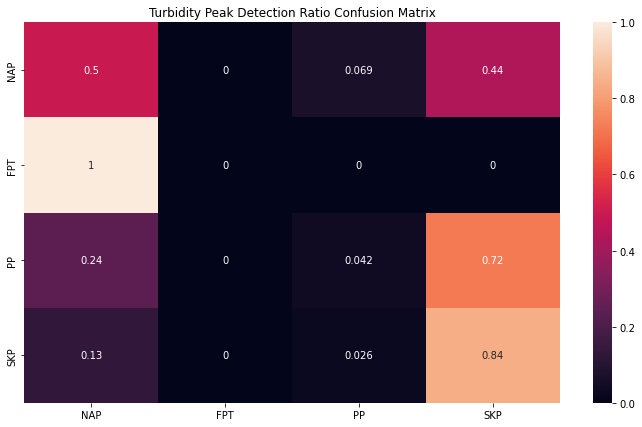

In [10]:
# Test model
model = torch.load("./results/models/turb/raw/may-sixth.pt")
model.eval()

y_pred = []
y_true = []

prog_bar = tqdm(testloader, desc="Testing", leave=False)
with torch.no_grad():
    for i, batch in enumerate(prog_bar):
        x = batch[0].to(device)

        y = batch[1].squeeze().to(device)

        outs = model(x.float())

        _, preds = torch.max(outs, 1)

        for label, prediction in zip(y, preds):
            # convert label and prediction to current vals
            label = le.inverse_transform([label])[0]
            prediction = le.inverse_transform([prediction])[0]

            y_pred.append(prediction)
            y_true.append(label)


# build conf matrix
conf = confusion_matrix(y_true, y_pred, labels=classes)

# review the classnames here
df_cm = pd.DataFrame(
    conf / conf.sum(axis=1)[:, np.newaxis],
    index=[i for i in classes],
    columns=[i for i in classes],
)

# classification report
acc_report = classification_report(y_true, y_pred)
print(acc_report)

bal_acc = balanced_accuracy_score(y_true, y_pred)
print(f"Balanced accuracy: {bal_acc}")

# display conf matrix
plt.figure(figsize=(12, 7))

plt.xlabel("Ground Truths")
plt.ylabel("Predictions")
plt.title(label="Turbidity Peak Detection Ratio Confusion Matrix")

plot = sn.heatmap(df_cm, annot=True)

plt.xlabel("Ground Truths")
plt.ylabel("Predictions")
plt.title(label="Turbidity Peak Detection Ratio Confusion Matrix")
plt.show()

plot.get_figure().savefig("./results/graphics/turb/raw/may-2.png")
